[View in Colaboratory](https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/mnist.ipynb)

In [2]:
!pip3 install torch torchvision

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('drive/My Drive/BScThesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import pickle
import sympy
from collections import defaultdict

In [0]:
from mnist_m import Mnist_M
from datasets_merge import Merge_Datasets

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  return torch.from_numpy(np.tile(img, (3,1,1)))

In [0]:
batch_size=64
num_workers=1

In [0]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(convertMnist)
                       ])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


In [0]:
def printMnist3D(image):
  image = image.numpy()
  image = image * 0.3081 + 0.1307
  plt.imshow(image.transpose(1,2,0), cmap='gray')

2


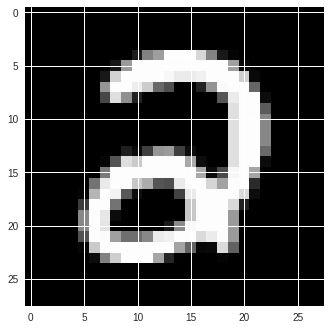

In [12]:
trainiter = iter(train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [0]:
def test(model, device, test_loader, no_print=False):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1] 
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  if no_print:
    return test_loss, correct
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [0]:
log_interval = 100

In [0]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.01
momentum=0.9

In [0]:
mnist_m_transform = transforms.Compose([
                           transforms.Normalize(3*[0.1307], 3*[0.3081]),
                       ])
mnist_m_train = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',
                        transform=mnist_m_transform)
mnist_m_test = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',train=False,
                     transform=mnist_m_transform)
mnist_m_train_loader = torch.utils.data.DataLoader(mnist_m_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_m_test_loader = torch.utils.data.DataLoader(mnist_m_test,
                                                  batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


tensor(5)


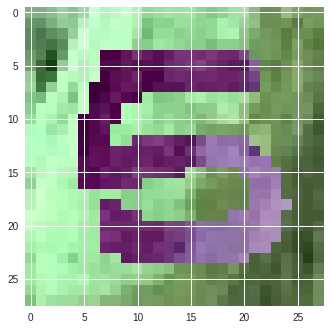

In [18]:
trainiter = iter(mnist_m_train_loader)
images, labels = trainiter.next()
printMnist3D(images[0])
print(labels[0])

In [0]:
mnist_ext_train = Merge_Datasets([train_set, mnist_m_train])
mnist_ext_test = Merge_Datasets([test_set, mnist_m_test])
mnist_ext_train_loader = torch.utils.data.DataLoader(mnist_ext_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_ext_test_loader = torch.utils.data.DataLoader(mnist_ext_test, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)



In [0]:
class GradReverse(torch.autograd.Function):
    def __init__(self, lambd=1.):
      self.lambd = lambd
    
    def forward(self, x):
        return x.view_as(x)

    def backward(self, grad_output):
        return (grad_output * -self.lambd)

def grad_reverse(x, lambd):
    return GradReverse(lambd)(x)

In [0]:
class MnistDomain(nn.Module):
  def __init__(self):
    super(MnistDomain, self).__init__()
    self.fc1 = nn.Linear(320, 100)
    self.fc2 = nn.Linear(100, 2)

  def forward(self, x, lambd=1.):
    x = grad_reverse(x, lambd)
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1) 
    

In [0]:
class MnistFeatureExtractor(nn.Module):
  def __init__(self):
    super(MnistFeatureExtractor, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
  def forward(self, x):
    x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
    x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    return x.view(-1, 320) 

In [0]:
class MnistClassPredictor(nn.Module):
  def __init__(self):
    super(MnistClassPredictor, self).__init__()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)    

In [0]:
criterion = F.nll_loss
criterion_domain = F.nll_loss

In [0]:
def concatDomainBatches(batches, shuffle=True):
  domain_num = np.arange(len(batches))[...,None]
  batch_len = len(batches[0])
  try:
    batches = torch.cat(batches).numpy()
  except:
    pass 
  domain_labels = (np.ones(batch_len) * domain_num).reshape(-1)
  if shuffle:
    idx = np.random.permutation(len(domain_labels))
    batches, domain_labels = batches[idx], domain_labels[idx].astype(np.long)
  return torch.from_numpy(batches), torch.from_numpy(domain_labels)

In [0]:
def trainWithDomain(model_f, model_c, model_d, device, train_loader_class, 
                    train_loader_domain, optim_f, optim_c, optim_d, 
                    epoch, epochs, use_lambd=True, train_domain=True,
                    train_history=defaultdict(lambda:[])):
  model_f.train()
  model_c.train()
  model_d.train()

  if train_domain:
    domain_iter = iter(train_loader_domain)
  lambd = -1.
  batch_num = len(train_loader.dataset) / train_loader.batch_size
  for batch_idx, (data, labels) in enumerate(train_loader):
    
    p = ((epoch-1) * batch_num + batch_idx) / (epochs * batch_num)
    lr = 0.01 / (1. + 10. * p)**0.75
    optim_f.lr = lr
    optim_c.lr = lr
    optim_d.lr = lr
    
    data = data.to(device)
    labels = labels.to(device)
    optim_f.zero_grad()
    optim_c.zero_grad()
    output = model_c(model_f(data))
    loss = criterion(output, labels)
    train_history['train_loss'].append(loss.item())
    loss.backward()
    
    optim_f.step()
    optim_c.step()
    if train_domain:
      data_snd, _ = domain_iter.next()
      domainData, domains = concatDomainBatches([data.to('cpu'), data_snd.to('cpu')])
      domainData, domains = domainData.to(device), domains.to(device)
      optim_f.zero_grad()
      optim_d.zero_grad()
      
      if use_lambd:
        lambd = 2. / (1. + np.exp(-10. * p)) - 1.   
      else:
        lambd = 1.
      output = model_d(model_f(domainData), lambd)
      loss_domain = criterion_domain(output, domains)
      train_history['domain_loss'].append(loss_domain)
      
      loss_domain.backward()
      optim_f.step()
      optim_d.step()
    
      model_d_mtx = model_d.fc1.weight.cpu().detach().numpy()
      model_c_mtx = model_c.fc1.weight.cpu().detach().numpy()
      train_history['sum_dot'].append(np.sum(model_c_mtx.dot(model_d_mtx.T)))
      train_history['avg_dot'].append(np.mean(model_c_mtx.dot(model_d_mtx.T)))  
    if batch_idx % log_interval == 0:
        print('Train Epoch: \
              {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, lr: {:.5f} lambd: {:.5f}'
            .format(epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item(), lr, lambd))
    

In [0]:
def testDomainModel(model_f, model_c, model_d, device, 
                    source_test_loader, target_test_loader, 
                    merged_test_loader, test_history=defaultdict(lambda:[])):
  model_f.eval()
  model_c.eval()
  model_d.eval()
  
  domain_test_loss = 0
  domain_correct = 0
  
  with torch.no_grad():
    class_model = nn.Sequential(model_f, model_c)
    domain_model = nn.Sequential(model_f, model_d)
    source_test_loss, source_correct = test(class_model, device,
                                            source_test_loader, no_print=True)
    target_test_loss, target_correct = test(class_model, device,
                                            target_test_loader, no_print=True)
    
    for data, target in merged_test_loader:
      data = data.to(device)
      _, domains = target
      domains = domains.to(device)
      
      domain_out = domain_model(data)
      domain_pred = domain_out.max(1, keepdim=True)[1] 
      domain_correct += domain_pred.eq(domains.view_as(domain_pred)).sum().item()
      
  domain_test_loss /= len(merged_test_loader.dataset)
  
  test_history['target_loss'].append(target_test_loss)
  test_history['source_loss'].append(source_test_loss)
  test_history['target_acc'].append(100. * target_correct / len(target_test_loader.dataset))
  test_history['source_acc'].append(100. * source_correct / len(source_test_loader.dataset))
  test_history['domain_acc'].append(100. * domain_correct / len(merged_test_loader.dataset))
  
  print('\nTarget Domain Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
      target_test_loss, target_correct, len(target_test_loader.dataset),
      100. * target_correct / len(target_test_loader.dataset)))
  print('\nSource Domain Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
      source_test_loss, source_correct, len(source_test_loader.dataset),
      100. * source_correct / len(source_test_loader.dataset)))
  print('\nDomains predictor:  Accuracy: {}/{} ({:.0f}%)\n'.format(
      domain_correct, len(merged_test_loader.dataset),
      100. * domain_correct / len(merged_test_loader.dataset)))
  

In [0]:
model_f = MnistFeatureExtractor().to(device)
model_c = MnistClassPredictor().to(device)
model_d = MnistDomain().to(device)
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum)


In [0]:
epochs=10

In [31]:
test_history = defaultdict(lambda:[])
train_history = defaultdict(lambda:[])
for epoch in range(1, epochs+1):
  trainWithDomain(model_f, model_c, model_d, device,train_loader,
                 mnist_m_train_loader, optim_f, optim_c,
                 optim_d, epoch, epochs, train_domain=True,
                 train_history=train_history)
  testDomainModel(model_f, model_c, model_d, device,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader,
                 test_history=test_history)

Train Epoch:               1 [0/60000 (0%)]	Loss: 2.319079, lr: 0.01000 lambd: 0.00000
Train Epoch:               1 [6400/60000 (11%)]	Loss: 0.547723, lr: 0.00927 lambd: 0.05328
Train Epoch:               1 [12800/60000 (21%)]	Loss: 0.521715, lr: 0.00865 lambd: 0.10626
Train Epoch:               1 [19200/60000 (32%)]	Loss: 0.478017, lr: 0.00812 lambd: 0.15865
Train Epoch:               1 [25600/60000 (43%)]	Loss: 0.389063, lr: 0.00766 lambd: 0.21015
Train Epoch:               1 [32000/60000 (53%)]	Loss: 0.339113, lr: 0.00726 lambd: 0.26052
Train Epoch:               1 [38400/60000 (64%)]	Loss: 0.689771, lr: 0.00690 lambd: 0.30951
Train Epoch:               1 [44800/60000 (75%)]	Loss: 0.170667, lr: 0.00658 lambd: 0.35690
Train Epoch:               1 [51200/60000 (85%)]	Loss: 0.191782, lr: 0.00630 lambd: 0.40253
Train Epoch:               1 [57600/60000 (96%)]	Loss: 0.242581, lr: 0.00604 lambd: 0.44624

Target Domain Test set: Average loss: 1.1855, Accuracy: 6562/10000 (66%)

Source Doma

In [32]:
mnist_pred = nn.Sequential(model_f, model_c)
test(mnist_pred, device, mnist_m_test_loader)


Test set: Average loss: 0.8445, Accuracy: 7357/10000 (74%)



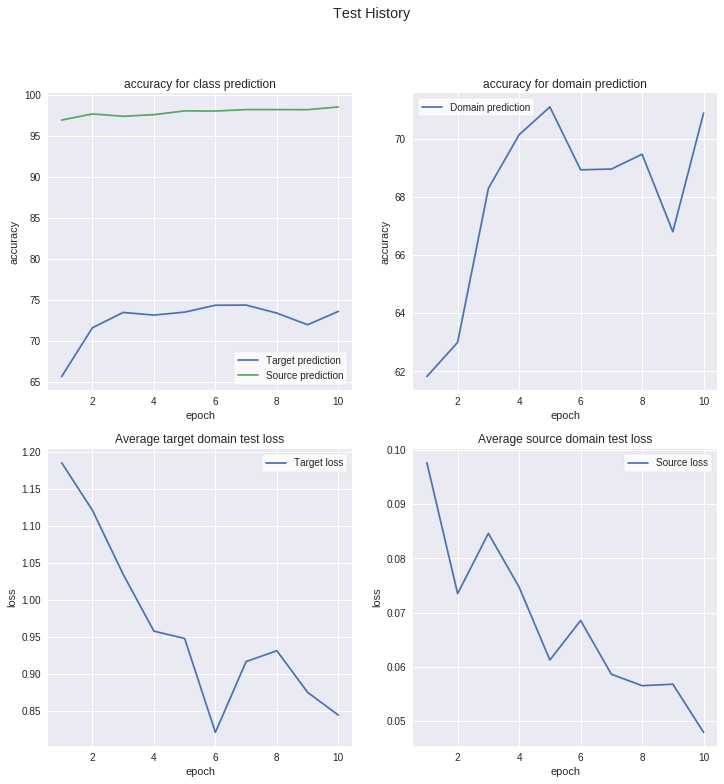

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

fig.suptitle('Test History')

epoch = np.arange(1,epochs+1)
axs[0][0].plot(epoch, np.array(test_history['target_acc']), label='Target prediction')
axs[0][0].plot(epoch, np.array(test_history['source_acc']), label='Source prediction')
axs[0][0].set_title('accuracy for class prediction')
axs[0][0].set_ylabel('accuracy')
axs[0][0].set_xlabel('epoch')
axs[0][0].legend(frameon=True, facecolor='white')

axs[0][1].plot(epoch, test_history['domain_acc'], label='Domain prediction')
axs[0][1].set_title('accuracy for domain prediction')
axs[0][1].set_ylabel('accuracy')
axs[0][1].set_xlabel('epoch')
axs[0][1].legend(frameon=True, facecolor='white')

axs[1][0].plot(epoch, test_history['target_loss'], label='Target loss')
axs[1][0].set_title('Average target domain test loss')
axs[1][0].set_ylabel('loss')
axs[1][0].set_xlabel('epoch')
axs[1][0].legend(frameon=True, facecolor='white')

axs[1][1].plot(epoch, test_history['source_loss'], label='Source loss')
axs[1][1].set_title('Average source domain test loss')
axs[1][1].set_ylabel('loss')
axs[1][1].set_xlabel('epoch')
axs[1][1].legend(frameon=True, facecolor='white')

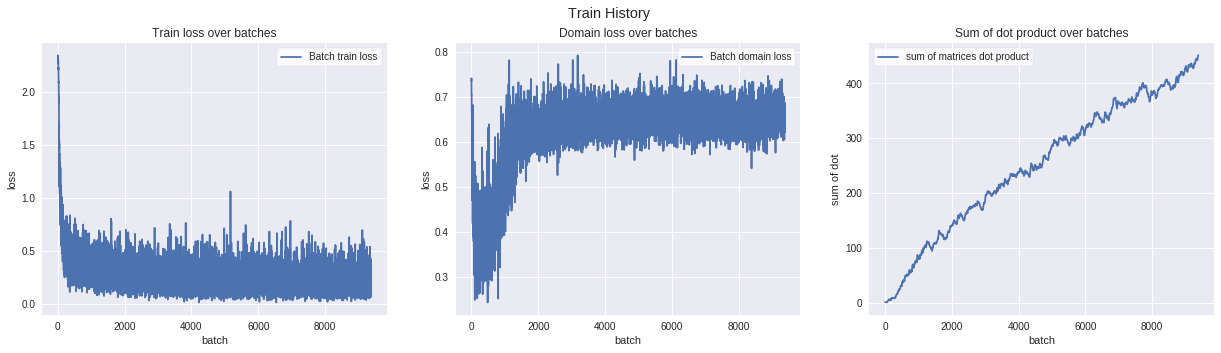

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(21,10))
fig.suptitle('Train History')


axs[0][0].plot(np.arange(len(train_history['train_loss'])), 
            train_history['train_loss'], label='Batch train loss')
axs[0][0].set_title('Train loss over batches')
axs[0][0].set_ylabel('loss')
axs[0][0].set_xlabel('batch')
axs[0][0].legend(frameon=True, facecolor='white')

axs[1][0].plot(np.arange(len(train_history['domain_loss'])), 
            train_history['domain_loss'], label='Batch domain loss')
axs[1][0].set_title('Domain loss over batches')
axs[1][0].set_ylabel('loss')
axs[1][0].set_xlabel('batch')
axs[1][0].legend(frameon=True, facecolor='white')

axs[0][1].plot(np.arange(len(train_history['sum_dot'])), 
            train_history['sum_dot'], label='sum of matrices dot product')
axs[0][1].set_title('Sum of dot product over batches')
axs[0][1].set_ylabel('sum of dot')
axs[0][1].set_xlabel('batch')
axs[0][1].legend(frameon=True, facecolor='white')

axs[1][1].plot(np.arange(len(train_history['avg_dot'])), 
            train_history['sum_dot'], label='avg of matrices dot product')
axs[1][1].set_title('Avg of dot product over batches')
axs[1][1].set_ylabel('avg of dot')
axs[1][1].set_xlabel('batch')
axs[1][1].legend(frameon=True, facecolor='white')



In [104]:
mnist_pred = nn.Sequential(model_f, model_c)
test(mnist_pred, device, test_loader)


Test set: Average loss: 0.0479, Accuracy: 9853/10000 (99%)



In [0]:
def trainDomain(model_f, model_d, device, train_loader, optimizer, epoch,
               history=True,  model_gr=None, model_c=None, train_history=None):
  model_d.train()
  model_f.eval()
  for batch_idx, (data, (_, domains)) in enumerate(train_loader):
    data, domains = data.to(device), domains.to(device)
    optimizer.zero_grad()
    output = model_d(model_f(data))
    loss = criterion_domain(output, domains)
    loss.backward()
    optimizer.step()
    if history:
      model_c_mtx = model_c.fc1.weight.cpu().detach().numpy()
      model_d_mtx = model_d.fc1.weight.cpu().detach().numpy()
      model_gr_mtx = model_gr.fc1.weight.cpu().detach().numpy()
      train_history['sum_dot'].append(np.sum(model_d_mtx.dot(model_c_mtx.T)))
      train_history['avg_dot'].append(np.mean(model_d_mtx.dot(model_c_mtx.T)))
      train_history['sum_dot_gr'].append(np.sum(model_d_mtx.dot(model_gr_mtx.T)))
      train_history['avg_dot_gr'].append(np.mean(model_d_mtx.dot(model_gr_mtx.T)))
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
  model_f.zero_grad()

In [0]:
def testDomainPred(model, device, merged_test_loader):
  model.eval()
  
  domain_test_loss = 0
  domain_correct = 0
  
  with torch.no_grad():    
    for data, target in merged_test_loader:
      data = data.to(device)
      _, domains = target
      domains = domains.to(device)
      
      domain_out = model(data)
      domain_pred = domain_out.max(1, keepdim=True)[1] 
      domain_correct += domain_pred.eq(domains.view_as(domain_pred)).sum().item()
      
  domain_test_loss /= len(merged_test_loader.dataset)

  print('\nDomains predictor:  Accuracy: {}/{} ({:.0f}%)\n'.format(
      domain_correct, len(merged_test_loader.dataset),
      100. * domain_correct / len(merged_test_loader.dataset)))

In [0]:
class Domain(nn.Module):
  def __init__(self):
    super(Domain, self).__init__()
    self.fc1 = nn.Linear(320, 100)
    self.fc2 = nn.Linear(100, 2)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [0]:
log_interval = 1000

In [96]:
epochs=3
domain_train_history = defaultdict(lambda:[])
domain_pred = Domain().to(device)
lr = 0.01
optim_domain = optim.SGD(domain_pred.parameters(), lr=lr, momentum=momentum)
for epoch in range(1, epochs+1):
  trainDomain(model_f, domain_pred, device, mnist_ext_train_loader, optim_domain,
              epoch, True, model_d, model_c, domain_train_history)
  testDomainPred(nn.Sequential(model_f, domain_pred), device, mnist_ext_test_loader)

Train Epoch: 1 [0/120000 (0%)]	Loss: 0.760654
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.378814

Domains predictor:  Accuracy: 18260/20000 (91%)

Train Epoch: 2 [0/120000 (0%)]	Loss: 0.321661
Train Epoch: 2 [64000/120000 (53%)]	Loss: 0.274671

Domains predictor:  Accuracy: 18486/20000 (92%)

Train Epoch: 3 [0/120000 (0%)]	Loss: 0.156022
Train Epoch: 3 [64000/120000 (53%)]	Loss: 0.228353

Domains predictor:  Accuracy: 18730/20000 (94%)



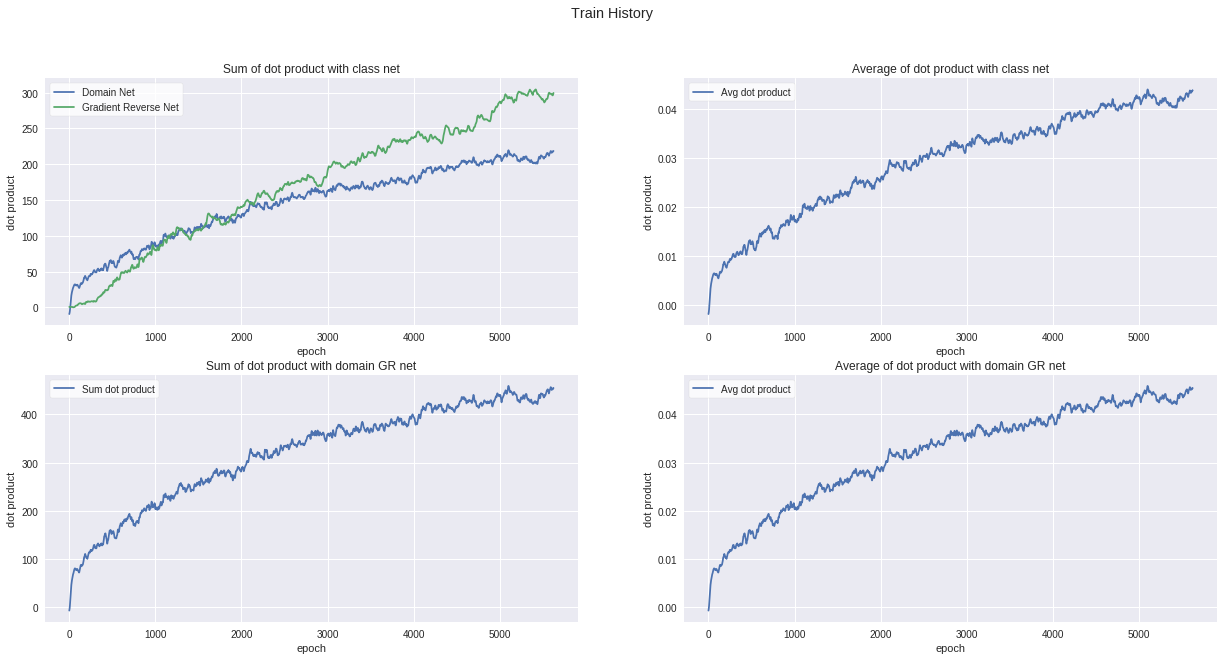

In [102]:
fig, axs = plt.subplots(2, 2, figsize=(21,10))

fig.suptitle('Train History')

histLen = len(domain_train_history['sum_dot'])
model_gr_dot_sum = train_history['matrices_dot'][:histLen]

axs[0][0].plot(np.arange(histLen), domain_train_history['sum_dot'],
               label='Domain Net')
axs[0][0].plot(np.arange(histLen), model_gr_dot_sum,
               label='Gradient Reverse Net')
axs[0][0].set_title('Sum of dot product with class net')
axs[0][0].set_ylabel('dot product')
axs[0][0].set_xlabel('epoch')
axs[0][0].legend(frameon=True, facecolor='white')

axs[0][1].plot(np.arange(histLen), domain_train_history['avg_dot'],
               label='Avg dot product')
axs[0][1].set_title('Average of dot product with class net')
axs[0][1].set_ylabel('dot product')
axs[0][1].set_xlabel('epoch')
axs[0][1].legend(frameon=True, facecolor='white')

axs[1][0].plot(np.arange(histLen), domain_train_history['sum_dot_gr'],
               label='Sum dot product')
axs[1][0].set_title('Sum of dot product with domain GR net')
axs[1][0].set_ylabel('dot product')
axs[1][0].set_xlabel('epoch')
axs[1][0].legend(frameon=True, facecolor='white')

axs[1][1].plot(np.arange(histLen), domain_train_history['avg_dot_gr'],
               label='Avg dot product')
axs[1][1].set_title('Average of dot product with domain GR net')
axs[1][1].set_ylabel('dot product')
axs[1][1].set_xlabel('epoch')
axs[1][1].legend(frameon=True, facecolor='white')


In [0]:
model_c_mtx = model_c.fc1.weight.cpu().detach().numpy()

In [0]:
model_d_mtx = model_d.fc1.weight.cpu().detach().numpy()

In [105]:
model_c_mtx.shape

(50, 320)

In [106]:
np.sum(model_c_mtx.dot(model_d_mtx.T))

450.80426

In [0]:
domain_pred_mtx = domain_pred.fc1.weight.cpu().detach().numpy()

In [108]:
np.mean(model_c_mtx.dot(domain_pred_mtx.T))

0.043688238

In [109]:
np.sum(domain_pred_mtx.dot(model_d_mtx.T))

454.57712

In [110]:
arr = np.array([[3,2], [6,1]])
np.linalg.matrix_rank(np.vstack((model_d_mtx, domain_pred_mtx, model_c_mtx)))

250

In [0]:
_, inds = sympy.Matrix(model_d_mtx).T.rref()

In [114]:
len(inds)

100

In [115]:
np.mean(np.sqrt(model_d_mtx**2))

0.040050726